# Import stuff and set default parameters

In [2]:
import matplotlib.pyplot as plt
import numpy as np
from scipy import optimize
from qutip import *
from functionsSqueeze import *

from platform import python_version

print(python_version())

3.7.3


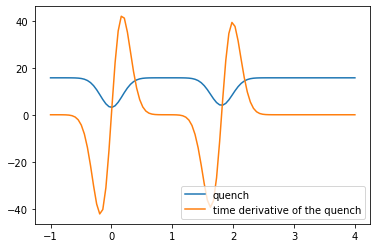

In [3]:
n = 50 # numerical accuracy
psi0 = thermal_dm(n, 0.01)
w0 = 2*np.pi * 2.5 # in MHz
T = 1/2.5

timesQQ = np.linspace(-1, 4, 500) # 200 steps per mu s and 80 steps per T=0.4 mu s
argsQQ = {'n': n,
   'omega': wQQ,
   'omegaDt': wQQdot,
   'omegaArgs': [w0, -0.8*w0, 0.18, -0.8*0.93*w0, 0.18, 1.8098867063776491],
   'f0': 100/(9*10**-15)}

ad = create(n)
a = destroy(n)
x = (ad + a)
p = 1j*(ad - a)

tlist = np.linspace(-1,4,100)
wDoubleQuench = wQQ(tlist, argsQQ['omegaArgs'])
wDoubleQuenchD = wQQdot(tlist, argsQQ['omegaArgs'])

plt.plot(tlist, wDoubleQuench, label="quench")
plt.plot(tlist, wDoubleQuenchD, label="time derivative of the quench")
plt.legend()
plt.show()

In [4]:
resultQQ = mesolve(H, psi0, timesQQ, args=argsQQ)

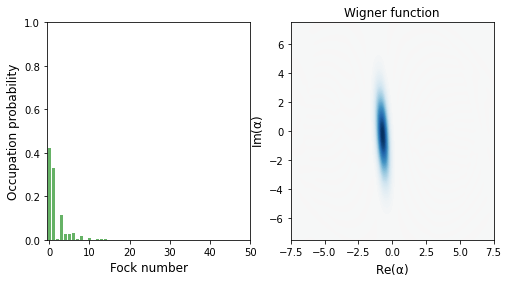

In [19]:
result = resultQQ
psi = result.states[400]

plot_wigner_fock_distribution(psi)
plt.show()

alpha =  0.5302426795661983 , xi =  (0.901136622200967+0.36051375961151577j)
 Progress: 100 %, processing time: 2 s

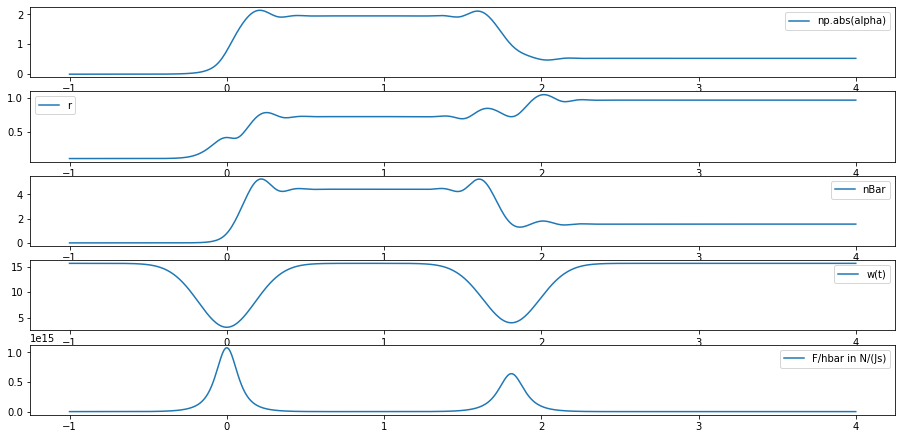

0

In [20]:
alpha, xi,_,_ = getParams(result.states[-1], calculate_nT = False)
print("alpha = ", np.abs(alpha), ", xi = ", xi)

plotResults(timesQQ, resultQQ, argsQQ, calculate_nT = False, nSkipp = 1, showProgress = True)

# evolution of $\alpha$ and $\xi$ in an undisturbed harmonic oscillator

<function matplotlib.pyplot.show(*args, **kw)>

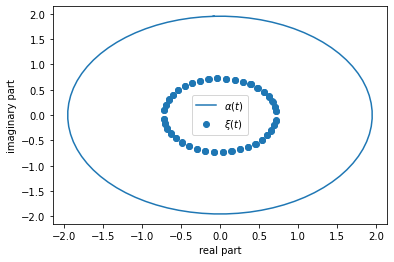

In [15]:
alphas = []
xis = []
for i in range(360, 441):
    alpha, xi,_,_ = getParams(result.states[i], calculate_nT = True)
    alphas.append(alpha)
    xis.append(xi)
    
plt.plot(np.real(alphas), np.imag(alphas), label = r'$\alpha(t)$')
plt.scatter(np.real(xis), np.imag(xis), label = r'$\xi(t)$')
plt.xlabel("real part")
plt.ylabel("imaginary part")
plt.legend()
plt.show

look at the evolution of $\alpha$ after the first pulse <br/>
two things are intuitive: 1 $\alpha$ is constant, 2 $\alpha$ circles around 0 (with Period T)<br/>
in case 1: second pulse should look different from the first one <br/>
in case 2: both pulses should look the same, but $\alpha$ should be at the opposite position at the beginning of pulse 2<br/> <br/>
evaluate for this $\alpha$ (and $\xi$) during one period T (= 40 timesteps)<br/> <br/>
RESULT: alpha circles with Period T

0 x T / 8


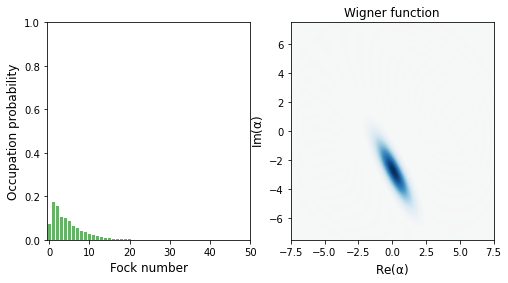

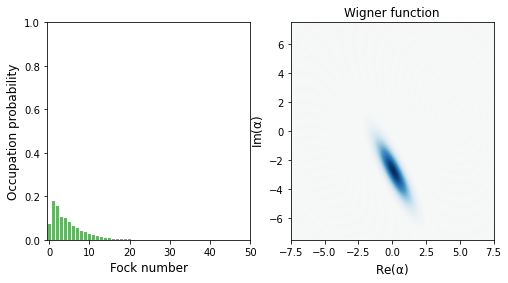

1 x T / 8


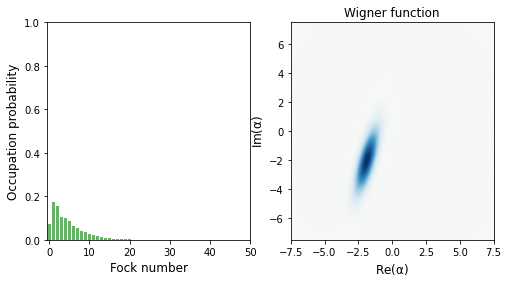

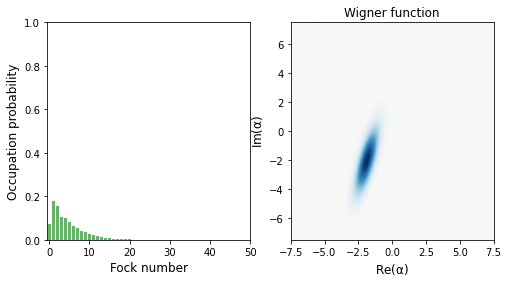

2 x T / 8


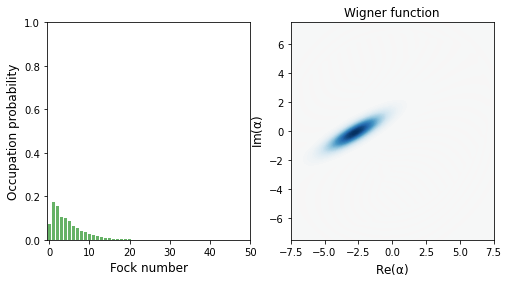

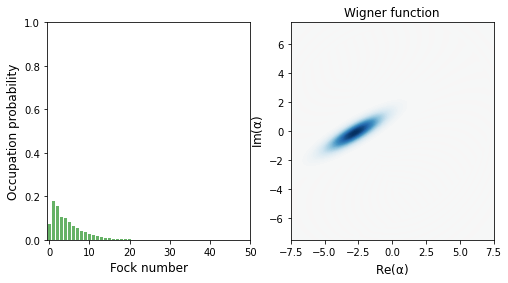

3 x T / 8


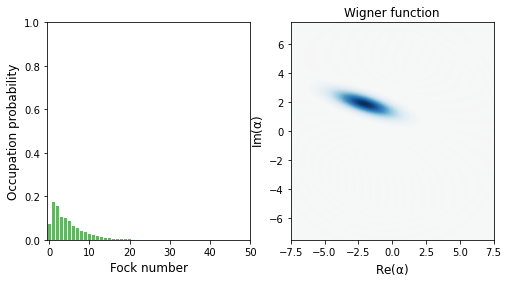

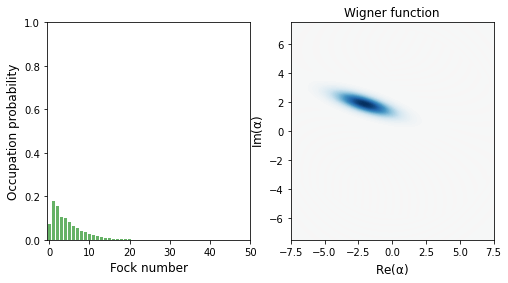

4 x T / 8


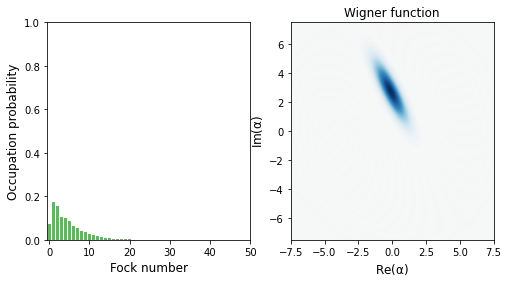

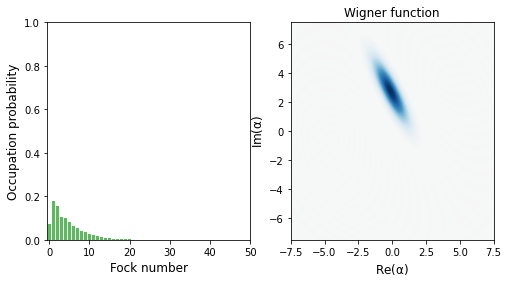

5 x T / 8


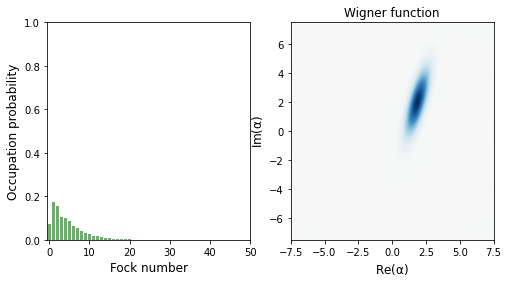

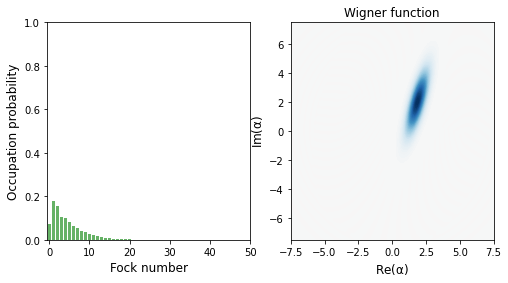

6 x T / 8


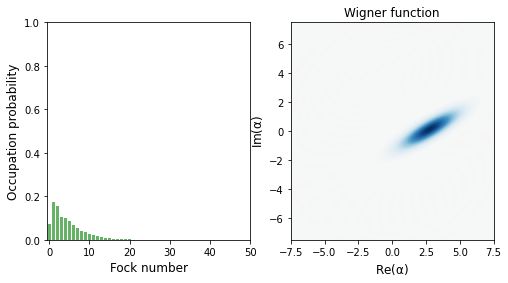

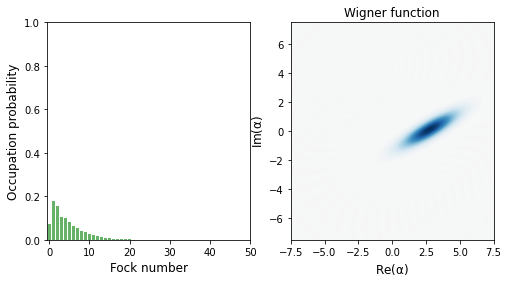

7 x T / 8


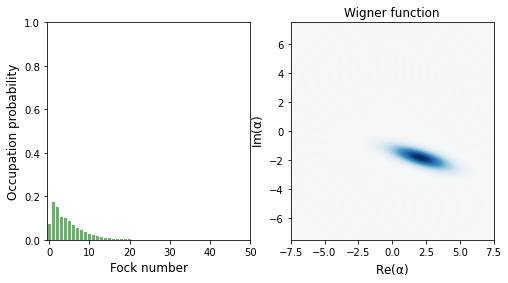

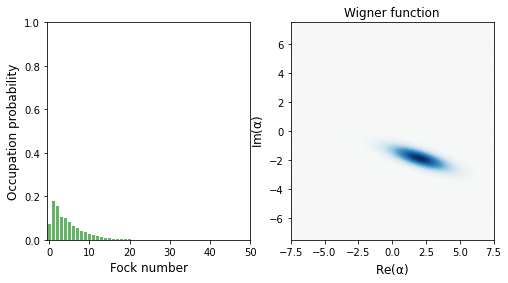

8 x T / 8


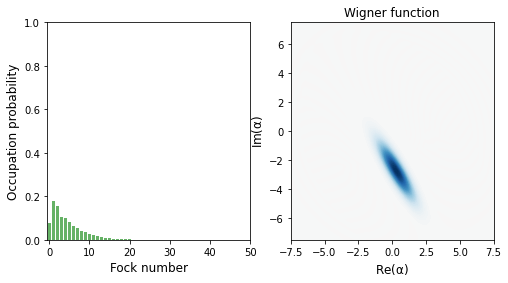

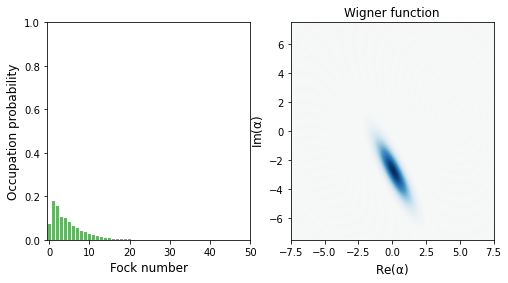

In [20]:
steps = 8

# get parameters of the initial state
alpha, xi, nBar, nT = getParams(result.states[400])
# print('|alpha|=', alpha, ', xi =', xi, ', nBar =', nBar, ', nT =', nT)
# print('xi =', np.abs(xi), 'exp(i x', np.angle(xi), ')')

for i in range(steps + 1):
    print(i, "x T /", steps)
    psi = result.states[int(400 + i*80/steps)]
    plot_wigner_fock_distribution(psi)
    plt.show()
    
    xi1 = xi*np.exp(-2*i * 2*np.pi/steps*1j)
    alpha1 = alpha*np.exp(-i * 2*np.pi/steps*1j)
    psi1 = displace(n, alpha1)*squeeze(n, xi1)*thermal_dm(n, nT)*squeeze(n, xi1).dag()*displace(n, alpha1).dag()
    plot_wigner_fock_distribution(psi1)
    plt.show()

evolution of the wiegner function in an undisturbed harmonic oscillator for a squeezed coherent state during one period $T = 2 \pi/w_0$. The coherent displacement rotates (in the complex plane $\mathbb{C}$) with circular frequency $w_0$ whereas the squeezing parameter $\xi$ rotates with circular frequency $2w_0$.

In [22]:
np.exp(-np.pi/2*1j)

(6.123233995736766e-17-1j)

# search the optimal delay between the two pulses and the optimal strength of the second pulse

In [129]:
# checking how |alpha| behaves when the delay is changed through 1 period T 
delayS = np.linspace(4*T, 5*T, 37) # at least 4T
alphaF = []

# speeding up things: only calculate the first quench once
times1 = np.linspace(-1, 2*T, 200)

# calculate time evolution over first quench and get final alpha (= alpha1)
resultQQ = mesolve(H, psi0, times1, args=argsQQ)
psi1 = resultQQ.states[-1]
alpha1 = np.sqrt(np.abs(expect(x, psi1)**2) + np.abs(expect(p, psi1)**2))

# calculate time evolution over second quench for several delays and get final alphas (= alpha2)
for dt in delayS:
    times2 = np.linspace(2*T, 3, 200)
    argsQQ['omegaArgs'][-1] = dt # only change the delay in argsQQ
    resultQQ = mesolve(H, psi1, times2, args=argsQQ) # calculate time evolution
    
    psi2 = resultQQ.states[-1] # final state
    alpha2 = np.sqrt(np.abs(expect(x, psi2)**2) + np.abs(expect(p, psi2)**2)) # get alpha
    alphaF.append(np.abs(alpha2)) # save alpha
    print('\r', "Progress:", round(100*(dt-delayS[0])/(delayS[-1]-delayS[0])), "%", end = '')

 Progress: 4.0 %%

In [8]:
# delayS = np.linspace(4*T, 5*T, 37)
# timesS = np.linspace(-1, 3, 401)
# psi0 = fock_dm(n)

# alphaF = scanAlphaXi(H, psi0, timesS, argsQQ, delayS, -1, skippInLoop = 0)

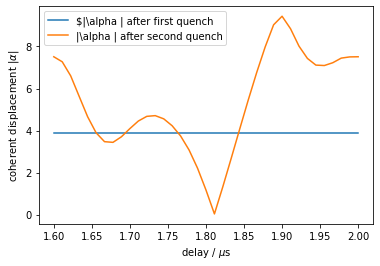

1.8098867063776491


In [130]:
# fit a quadratic polynom on the minimum to get a more exact position
def fitFkt(x, a, b, c):
    return(a*x**2 + b*x + c)

# take two points left and right of the minimum for the quadratic fit
idx = alphaF.index(min(alphaF))
xFit = delayS[idx-2:idx+3]
yFit = alphaF[idx-2:idx+3]
params,_ = optimize.curve_fit(fitFkt, xFit, yFit, p0 = [0, 0, 0]) # do the fit

# plot the results from above
plt.plot([delayS[0], delayS[-1]], [np.abs(alpha1), np.abs(alpha1)], label = r'$|\alpha |$ after first quench')
plt.plot(delayS, alphaF, label = r'$|\alpha |$ after second quench')

# plot the fit
# xlist = np.linspace(xFit[0]-0.03, xFit[-1]+0.03, 1000)
# plt.plot(xlist, fitFkt(xlist, params[0], params[1], params[2]), label = "quadratic fit around the minimum")
# plt.scatter(xFit, yFit, label = "points taken for the quadratic fit")
plt.legend()
plt.xlabel(r'delay / $\mu$s')
plt.ylabel(r'coherent displacement $|\alpha |$')
plt.show()

delayOpt = -params[1]/(2*params[0])
print(delayOpt)

coherent displacement for different delays between the two pulses <br/>
After a two pulse sequence, the absolute value of the coherent displacement is calculated for delays $\Delta T \in \left[4T, 5T\right]$ (with T = 0.4 $\mu s$ the period of the unpertubed signal) between the two pulses. A minimum is visible in the first half of the peiod.

In [122]:
# check if the number off full periods T between the two quenches plays a role (result: No)
delays = np.linspace(delayOpt, delayOpt + 12*T, 13) # at least 4T
alphaF2 = []

# speeding up things: only calculate the first quench once
times1 = np.linspace(-1, 2*T, 200)

# calculate time evolution over first quench and get final alpha (= alpha1)
resultQQ = mesolve(H, psi0, times1, args=argsQQ)
psi1 = resultQQ.states[-1]
alpha12,_,_,_ = getParams(psi1, False)

# calculate time evolution over second quench for several delays and get final alphas (= alpha2)
i = 0
for dt in delays:
    times2 = np.linspace(2*T, dt + 2*T, 200+50*i) # keep spacing the same
    argsQQ['omegaArgs'][-1] = dt # only change the delay in argsQQ
    resultQQ = mesolve(H, psi1, times2, args=argsQQ) # calculate time evolution
    
    psi2 = resultQQ.states[-1] # final state
    alpha2,_,_,_ = getParams(psi2, False) # get alpha
    alphaF2.append(np.abs(alpha2)) # save alpha
    i += 1
    print('\r', "Progress: ", round(100*(dt-delays[0])/(delays[-1]-delays[0])), " %", end = '')

 Progress:  100.0  %

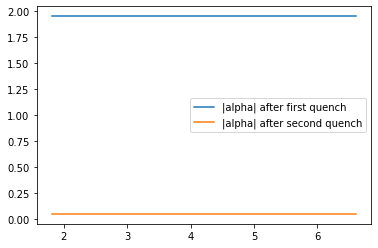

In [123]:
plt.plot([delays[0], delays[-1]], [np.abs(alpha12), np.abs(alpha12)], label = "|alpha| after first quench")
plt.plot(delays, alphaF2, label = "|alpha| after second quench")
plt.legend()
plt.show()

coherent displacement for different delays between the two pulses <br/>
After a two pulse sequence, the absolute value of the coherent displacement is calculated for delays $\Delta T = t_0 + n \cdot T$ (with T = 0.4 $\mu s$ the period of the unpertubed signal, $t_0$ at the minimum from figure above, $n \in \{0, 1, 2, \dots, 12\}$) between the two pulses. No dependance on $n$ is visible.

In [35]:
# check the influence of the second quenches strength (=> should be the same as the first one)
# make sure to use the optimal delay (see above)

dw2s = np.linspace(-0.9, -0.5, 41)
alphaF3 = []

# speeding up things: only calculate the first quench once
times1 = np.linspace(-1, 2*T, 200)

# calculate time evolution over first quench and get final alpha (= alpha1)
resultQQ = mesolve(H, psi0, times1, args=argsQQ)
psi1 = resultQQ.states[-1]
# alpha13,_,_,_ = getParams(psi1, False)
alpha13 = np.sqrt(np.abs(expect(x, psi1)**2) + np.abs(expect(p, psi1)**2))

# calculate time evolution over second quench for several dw2s and get final alphas (= alpha2)
times2 = np.linspace(2*T, 3, 200)
for dw2 in dw2s:
    argsQQ['omegaArgs'][3] = dw2*w0 # only change the secon pule strength in argsQQ    
    resultQQ = mesolve(H, psi1, times2, args=argsQQ) # calculate time evolution

    psi2 = resultQQ.states[-1] # final state
#     alpha2,_,_,_ = getParams(psi2, False) # get alpha
    alpha2 = np.sqrt(np.abs(expect(x, psi2)**2) + np.abs(expect(p, psi2)**2)) # get alpha
    alphaF3.append(np.abs(alpha2)) # save alpha
    print('\r', "Progress: ", round(100*(dw2-dw2s[0])/(dw2s[-1]-dw2s[0])), " %", end = '')

 Progress:  100.0  %

In [37]:
# check the influence of the second quenches strength (=> should close to the first one)
# make a better search around the minimum from above
# make sure to use the optimal delay (see above)

dw2Opt = dw2s[alphaF3.index(min(alphaF3))]

dw2sexact = np.linspace(dw2Opt-0.01, dw2Opt+0.01, 21) # 0.01 is the stepsize above
alphaF3exact = []

# speeding up things: only calculate the first quench once
times1 = np.linspace(-1, 2*T, 200)

# calculate time evolution over first quench and get final alpha (= alpha1)
resultQQ = mesolve(H, psi0, times1, args=argsQQ)
psi1 = resultQQ.states[-1]
# alpha13,_,_,_ = getParams(psi1, False)
# alpha13 = np.sqrt(np.abs(expect(x, psi1)**2) + np.abs(expect(p, psi1)**2))

# calculate time evolution over second quench for several dw2s and get final alphas (= alpha2)
times2 = np.linspace(2*T, 3, 200)
for dw2 in dw2sexact:
    argsQQ['omegaArgs'][3] = dw2*w0 # only change the secon pule strength in argsQQ    
    resultQQ = mesolve(H, psi1, times2, args=argsQQ) # calculate time evolution

    psi2 = resultQQ.states[-1] # final state
#     alpha2,_,_,_ = getParams(psi2, False) # get alpha
    alpha2 = np.sqrt(np.abs(expect(x, psi2)**2) + np.abs(expect(p, psi2)**2)) # get alpha
    alphaF3exact.append(np.abs(alpha2)) # save alpha
    print('\r', "Progress: ", round(100*(dw2-dw2sexact[0])/(dw2sexact[-1]-dw2sexact[0])), " %", end = '')

 Progress:  100.0  %

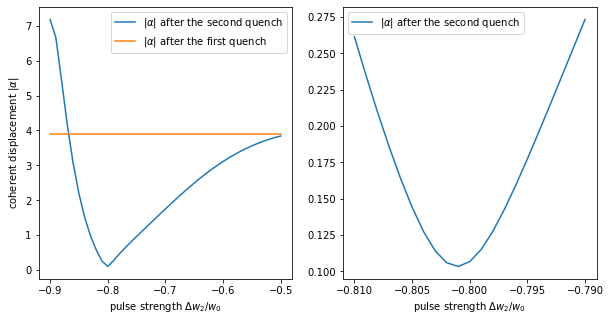

-0.801


In [56]:
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_size_inches(10, 5, forward=True)
ax1.plot(dw2s, alphaF3, label = r'$|\alpha|$ after the second quench')
ax1.plot([dw2s[0], dw2s[-1]], [np.abs(alpha13), np.abs(alpha13)], label = r'$|\alpha|$ after the first quench')
ax1.legend()
ax1.set(xlabel=r'pulse strength $\Delta w_2 / w_0$', ylabel=r'coherent displacement $|\alpha |$')

ax2.plot(dw2sexact, alphaF3exact, label = r'$|\alpha|$ after the second quench')
ax2.legend()
ax2.set(xlabel=r'pulse strength $\Delta w_2 / w_0$')
plt.show()

dw2Optexact = dw2sexact[alphaF3exact.index(min(alphaF3exact))]
print(dw2Optexact)

coherent displacement for different strengths of the second pulse <br/>
After a two pulse sequence, the absolute value of the coherent displacement is calculated for different strengths of the second pulse $\Delta w_2 = \gamma \cdot w_0$ (with $w_0 = 2\pi \cdot 2.5$ MHz the unperturbed circular frequency, $\gamma \in \left[-0.9, -0.3\right]$). A minimum is at the position $\Delta w_2 = 0.8 \cdot w_0 = \Delta w_1$ which corresponds to the strength of the first pulse.

In [ ]:
# do a grid search around the minimum found
delayOpt = 1.8099751290225832
dw2Opt = -0.8

delaysg = np.linspace(delayOpt - 0.005, delayOpt + 0.01, 4) # Stepsize is 0.005, above it was 0.01
dw2sg = np.linspace(dw2Opt - 0.02, dw2Opt + 0.04, 4) # same stepsize as above
alphaFg = []
paramsListg = []

# speeding up things: only calculate the first quench once
times1 = np.linspace(-1, 2*T, 200)

# calculate time evolution over first quench and get final alpha (= alpha1)
resultQQ = mesolve(H, psi0, times1, args=argsQQ)
psi1 = resultQQ.states[-1]
alpha1g,_,_,_ = getParams(psi1, False)

# calculate time evolution over second quench for several delays and get final alphas (= alpha2)
times2 = np.linspace(2*T, 3, 200)
for dt in delaysg:
    for dw2 in dw2sg:
        argsQQ['omegaArgs'][3] = dw2*w0
        argsQQ['omegaArgs'][-1] = dt # only change the delay in argsQQ
        resultQQ = mesolve(H, psi1, times2, args=argsQQ) # calculate time evolution

        psi2 = resultQQ.states[-1] # final state
        alpha2g,_,_,_ = getParams(psi2, False) # get alpha
        alphaFg.append(np.abs(alpha2g)) # save alpha
        paramsListg.append([dt, dw2])
        print('\r', "Progress dt:", round(100*(dt-delaysg[0])/(delaysg[-1]-delaysg[0])), "%, Progress dw:", round(100*(dw2-dw2sg[0])/(dw2sg[-1]-dw2sg[0])), " %",end = '')

In [ ]:
idxg = alphaFg.index(min(alphaFg))
print(alphaFg[idxg], paramsListg[idxg])

# Theoretical calculations on the quenching operator

in this section, I try to reproduce predictions from theoretical considerations concerning the quenching operator $Q$<br/>
First I assume $Q$ can be written as infinite series of squeezing operator after displaysment operator, which leads to not so good results (both theoretical and then the calculation of these predictions)<br/>
Second I assume $Q = D(\alpha) S(\xi)$, which leads to nice results

|alpha|= 1.9089449058305008 , xi = 0.7445947082638125 , nBar = 4.308834591727924 , nT = 5.918334664173196e-07
|alpha|= 0.2976376100100826 , xi = 1.0052068442190116 , nBar = 1.4886728301574919 , nT = 5.925227628495373e-07


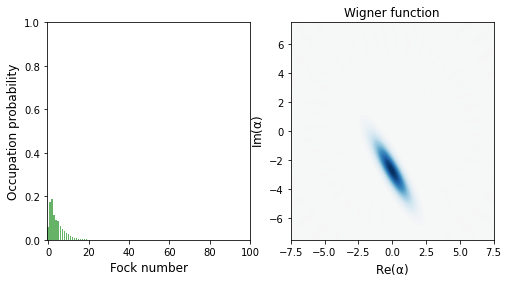

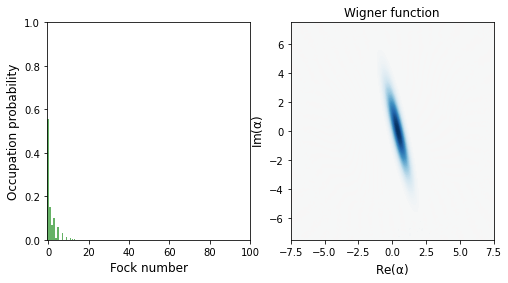

In [8]:
# Assume

n = 100

argsNix = {'n': n,
       'omega': wQP,
       'omegaDt': wQPdot,
       'omegaArgs': [w0, 0, 0.18, 0, 0, 0.],
       'f0': 0}

xi0 = 0.34839 +0.658062j
alpha0 = -0.0190384 -1.90885j
psi0 = fock_dm(n, 0)

psi1 = displace(n, alpha0)*squeeze(n, xi0) *psi0* squeeze(n, xi0).dag()*displace(n, alpha0).dag()
plot_wigner_fock_distribution(psi1)

phi = -0.37
timesNix = np.linspace(0, phi*T, 100)
resultNix = mesolve(H, psi1, timesNix, args=argsNix)
psi2 = resultNix.states[-1]
# plot_wigner_fock_distribution(psi2)

xi1 = 0.264464 +0.499537j
alpha1 = -0.265918 -1.1022j
psi3 = displace(n, alpha1)*squeeze(n, xi1) *psi2* squeeze(n, xi1).dag()*displace(n, alpha1).dag()
plot_wigner_fock_distribution(psi3)

# alpha, xi, nBar, nT = getParams(psi1)
# print('|alpha|=', np.abs(alpha), ', xi =', np.abs(xi), ', nBar =', nBar, ', nT =', nT)
alpha, xi, nBar, nT = getParams(psi2)
print('|alpha|=', np.abs(alpha), ', xi =', np.abs(xi), ', nBar =', nBar, ', nT =', nT)
alpha, xi, nBar, nT = getParams(psi3)
print('|alpha|=', np.abs(alpha), ', xi =', np.abs(xi), ', nBar =', nBar, ', nT =', nT)

In [31]:
deltaT = -2*np.pi*1j*0.643368/T
alpha1 = (-0.0190384 - 1.90885j)*np.exp(deltaT)
alpha2 = -0.158869 - 1.53141j
xi1 = (0.34839 + 0.658062j)*np.exp(2*deltaT)
xi2 = 0.311284 + 0.587975j

opQ = displace(n, alpha1)*squeeze(n, xi1)
opQQ = displace(n, alpha2)*squeeze(n, xi2)*displace(n, alpha1)*squeeze(n, xi1)

|alpha|= (1.2168736120218722+1.470809782774125j) , xi = (0.723236528349471-0.2185430788380217j) , nBar = 4.332129000836538 , nT = 0.010378671485756252
|alpha|= (0.0014268082639255428-0.00026107980862309903j) , xi = (0.9236364436047847+0.7701406413715267j) , nBar = 2.2927963167713767 , nT = 0.018011835338001436


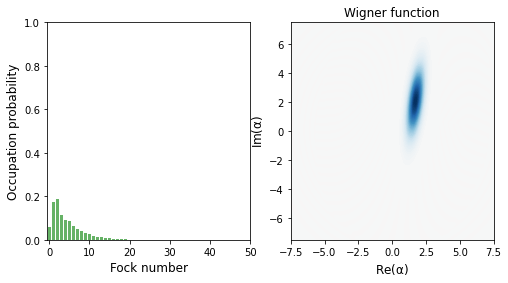

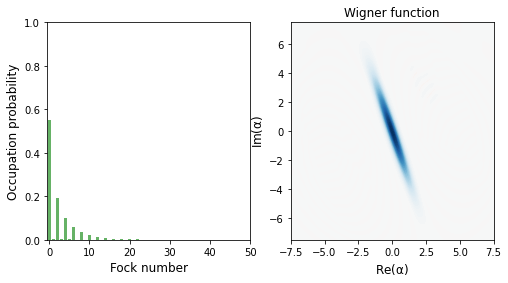

In [32]:
psi1 = opQ*thermal_dm(n, 0.01)*opQ.dag()
psi2 = opQQ*thermal_dm(n, 0.01)*opQQ.dag()

alpha, xi, nBar, nT = getParams(psi1)
print('|alpha|=', alpha, ', xi =', xi, ', nBar =', nBar, ', nT =', nT)

alpha, xi, nBar, nT = getParams(psi2)
print('|alpha|=', alpha, ', xi =', xi, ', nBar =', nBar, ', nT =', nT)

plot_wigner_fock_distribution(psi1)
plt.show()
plot_wigner_fock_distribution(psi2)
plt.show()

State after the action $Q_2 R(t) Q_1$ of two quench operators $Q_1 = D(\alpha(1)) S(\xi(1))$, $Q_2 = D(\alpha(\gamma)) S(\xi(\gamma))$, with $\alpha(\gamma)$ and $\xi(\gamma)$ functions of the pulse strength relative to the first pulse strength (see fits in the squeezed file), $R(t)$ evolution of the state for time $t$ in the undisturbed harmonic oscillator. $\gamma$ and $t$ are taken from theoretical calculations (see mathematica, section "Now assume $Q = D(\alpha) S(\xi)$") for minimal coherent displacement.<br/>
Since the state obtained has quite small coherent displacement, it shows that the calculations are not too bad.